In [155]:
import sqlite3
from sqlite3 import Error
import os.path
from os import path

from create_db import create_connection, create_table, clean_column_names
from populate_db import extract_data, insert_records
import query_db as qd
import config
import build_dataset as build

import importlib
import datetime
import re
import numpy as np
import pandas as pd


In [180]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold, cross_val_score, PredefinedSplit
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
# Decision Tree
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import ParameterGrid
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import ParameterGrid
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


In [217]:
importlib.reload(build)
importlib.reload(config)

<module 'config' from '/Users/daminisharma/Dropbox/Harris MSCAPP/2019-20_Q3_Spring/Machine Learning/covid_decarceration/files/config.py'>

In [121]:
dataset_1 = pd.read_csv('../data/dataset_main_active1.csv')
dataset_3 = pd.read_csv('../data/dataset_main_active3.csv')

/Users/daminisharma/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (21,22,29,30,32) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [122]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [206]:
dataset_1.head(2)

,ID,COMMITMENT_PREFIX,EARLIEST_SENTENCE_EFFECTIVE_DT,MOST_SERIOUS_OFFENSE_CODE,INMATE_COMPUTATION_STATUS_FLAG,END_DATE,PROJ_END_DATE,INMATE_RECORD_STATUS_CODE,INMATE_ADMIN_STATUS_CODE,DATE_OF_LAST_INMATE_MOVEMENT,TYPE_OF_LAST_INMATE_MOVEMENT,CURRENT_COMMITMENT_PREFIX,CONTROL_STATUS,GENDER,RACE,BIRTH_DATE,STATE_BORN,ETHNICITY,CITIZENSHIP,PRIMARY_OFFENSE_CODE,NextPrefix,NextStart,NextOffense,new_col,Time_Diff,Recidivate,INFRACTION_PER_SENT,felon_count,misd_count,Primary offense code_x,Description (if needed)_x,Recidivate_Risk_Level,Needed a check?_x,Recidivate_Risk_Level_Lenient,Recidivate_Risk_Level_Harsh,Primary offense code_y,Description (if needed)_y,Current_Offense_Risk_Level,Needed a check?_y,Current_Offense_Risk_Level_Lenient,Current_Offense_Risk_Level_Harsh,age_at_sentence,date_to_merge
0,4,AA,1983-07-12,SELL SCHEDULE II,EXPIRED,1984-07-11,1984-07-11,INACTIVE,INACTIVE,1984-07-11,TERMINATED PAROLE,NaN,REGULAR POPULATION RPOP,MALE,WHITE,1961-10-15,ALASKA,UNKNOWN,BORN IN U.S.,SELL SCHEDULE II,NONE,NaN,0,0,NaN,0.0,0.0,2.0,0.0,NaN,NaN,0.0,NaN,0.0,0.0,SELL SCHEDULE II,Selling drugs on Schedule II - high potential ...,3.0,YES,2.0,4.0,21.0,1983-07
1,6,AA,1973-01-30,WORTHLESS CHECK,EXPIRED,1973-03-28,0001-01-01,INACTIVE,INACTIVE,1975-08-18,TERMINATED PAROLE,NaN,REGULAR POPULATION RPOP,MALE,WHITE,1951-07-17,NORTH CAROLINA,UNKNOWN,BORN IN U.S.,WORTHLESS CHECK,AB,1973-04-11,WORTHLESS CHECK,1973,0.0,1.0,0.0,0.0,1.0,WORTHLESS CHECK,0,1.0,NO,1.0,1.0,WORTHLESS CHECK,0,1.0,NO,1.0,1.0,21.0,1973-01


In [218]:
# BINARY TARGET VAR
grouping_target = config.grouping_target
print(grouping_target)
#print(features)
train_data, test_data, validate_data, active_sentences = build.split_and_process(dataset_1,config,grouping_target)


binary
249
Size of active sentences dataset:  32711
Dataset size:  778681


/Users/daminisharma/Dropbox/Harris MSCAPP/2019-20_Q3_Spring/Machine Learning/covid_decarceration/files/build_dataset.py:601: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_no_active[target_label] = dataset_no_active['label']


Total Number of Unique IDs: 419118
Total Number of IDs in Test Data: 83824
Total Number of IDs in Train Data: 268235
Total Number of IDs in Validate Data: 67059
Do the IDs add up? True
Does Test Represent 20% of the data? False
Test Represents X% of the data: 0.20000095438516122
Does Train+Validate Represent 80% of the data? False
Train+Validate Represents X% of the data: 0.7999990456148388
Does Validate Represent 20% of the Train+Validate Data?: 0.20000059649143737
Does Train Represent 80% of the Train+Validate Data?: 0.7999994035085627
Index(['CONTROL_STATUS', 'OFFENSE_CLEAN', 'Current_Offense_Risk_Level',
       'year_month', 'INFRACTION_PER_SENT', 'misd_count', 'felon_count',
       'sentence_count', 'age_at_sentence', 'unemp_rate', 'ID',
       'COMMITMENT_PREFIX', 'BIRTH_DATE', 'EARLIEST_SENTENCE_EFFECTIVE_DT',
       'INMATE_ADMIN_STATUS_CODE', 'NextPrefix', 'Recidivate_Risk_Level',
       'age_cat', 'age_first_offense', 'juv_first_offense',
       'current_crime_violent'],
    

In [219]:
# Sanity Check
print('Train and Test Check:')
build.sanity_check(train_data,test_data)

print('Train and Validate Check:')
build.sanity_check(train_data,validate_data)

print('Train and Active Check:')
build.sanity_check(train_data,active_sentences)



Train and Test Check:
Success: Features match
Success: No NAs remain
Train and Validate Check:
Success: Features match
Success: No NAs remain
Train and Active Check:
Success: Features match


In [255]:
validate_data.groupby(target).count()

,INFRACTION_PER_SENT,misd_count,felon_count,sentence_count,age_at_sentence,unemp_rate,age_first_offense,juv_first_offense,current_crime_violent,CONTROL_STATUS_HIGH SECURITY/MAX CONTROL HCON,CONTROL_STATUS_INTENSIVE CONTROL ICON,CONTROL_STATUS_MAXIMUM CONTROL MCON,CONTROL_STATUS_MODIFIED HOUSING MODH,CONTROL_STATUS_PROTECTIVE CONTROL PCON,CONTROL_STATUS_REGULAR POPULATION RPOP,CONTROL_STATUS_REST.HOUS. ADMINISTRATIVE RHAP,CONTROL_STATUS_REST.HOUS. DISCIPLINARY RHDP,CONTROL_STATUS_RESTRCT HOUSNG 4 CTL PURP RHCP,OFFENSE_CLEAN_ARMED ROBBERY,OFFENSE_CLEAN_ASSAULT BY STRANGULATION,OFFENSE_CLEAN_ASSAULT INFLICT SERI BODY INJ,OFFENSE_CLEAN_ASSAULT ISI,OFFENSE_CLEAN_ASSAULT ON FEMALE,OFFENSE_CLEAN_ASSAULT ON OFFICER/ST EMPLOYEE,OFFENSE_CLEAN_ASSAULT ON POLICEMAN,OFFENSE_CLEAN_ASSAULT ON PUBLIC OFFICIAL,OFFENSE_CLEAN_AWDW,OFFENSE_CLEAN_AWDW GOV OFFICERS/EMPLOYEES,OFFENSE_CLEAN_AWDWISI,OFFENSE_CLEAN_AWDWWITKISI,OFFENSE_CLEAN_B & E & L,OFFENSE_CLEAN_B & E VEHICLES,OFFENSE_CLEAN_BURGLARY 1ST DEGREE,OFFENSE_CLEAN_BURGLARY 2ND DEGREE,OFFENSE_CLEAN_CHEAT - PROPERTY/SERVICES,OFFENSE_CLEAN_COMMON LAW FORGERY,OFFENSE_CLEAN_COMMON LAW ROBBERY,OFFENSE_CLEAN_COMMUNICATING THREATS,OFFENSE_CLEAN_CREDIT CARD THEFT,OFFENSE_CLEAN_DAMAGE TO PROPERTY,OFFENSE_CLEAN_DEL/SELL SCHEDULE II,OFFENSE_CLEAN_DISCHG FIREARM-OCC PROPERTY,OFFENSE_CLEAN_DRIV LICENSE PERM RVK,OFFENSE_CLEAN_DRIV LICENSE REVOKED,OFFENSE_CLEAN_DRIVING UNDER INFLUENCE (DUI),OFFENSE_CLEAN_DRUG PARA - USE/POSSESS,OFFENSE_CLEAN_DWI DRIVING WHILE IMPAIRED,OFFENSE_CLEAN_DWI LEVEL 1,OFFENSE_CLEAN_DWI LEVEL 1 AGGRAVATED,OFFENSE_CLEAN_DWI LEVEL 2,OFFENSE_CLEAN_DWI LEVEL 3,OFFENSE_CLEAN_DWI LEVEL 4,OFFENSE_CLEAN_DWI LEVEL 5,OFFENSE_CLEAN_EMBEZZLEMENT,OFFENSE_CLEAN_FAIL TO REGISTER (SEX OFFENDER,OFFENSE_CLEAN_FELONY B&E,OFFENSE_CLEAN_FORGERY,OFFENSE_CLEAN_HABITUAL FELON,OFFENSE_CLEAN_HABITUAL IMPAIRED DRIVING,OFFENSE_CLEAN_HABITUAL MISDEMEANOR ASSAULT,OFFENSE_CLEAN_IDENTITY FRAUD/THEFT,OFFENSE_CLEAN_INDECENT LIBERTY W/CHILD,OFFENSE_CLEAN_INVOLUNTARY MANSLAUGHTER,OFFENSE_CLEAN_KIDNAPPING 2ND DEGREE,OFFENSE_CLEAN_LARCENY,OFFENSE_CLEAN_LARCENY (OVER $200),OFFENSE_CLEAN_LARCENY AFTER B & E,OFFENSE_CLEAN_LARCENY BY SERVANT/EMPLOYEE,OFFENSE_CLEAN_LARCENY FROM PERSON,OFFENSE_CLEAN_LARCENY OF FIREARMS,OFFENSE_CLEAN_LARCENY OF MOTOR VEHICLE,OFFENSE_CLEAN_LARCENY OVER $1000,OFFENSE_CLEAN_MAINT ANY PLACE CONTR SUB,OFFENSE_CLEAN_MANSLAUGHTER,OFFENSE_CLEAN_MISD B&E,OFFENSE_CLEAN_MURDER FIRST DEGREE,OFFENSE_CLEAN_MURDER SECOND DEGREE,OFFENSE_CLEAN_NON-SUPPORT,OFFENSE_CLEAN_OBT PROP BY FALSE PR/CHTS/SER,OFFENSE_CLEAN_OPERATE VEHICLE W/O LICENSE,OFFENSE_CLEAN_OTHER,OFFENSE_CLEAN_POSSESS SCHEDULE I,OFFENSE_CLEAN_POSSESS SCHEDULE II,OFFENSE_CLEAN_POSSESS SCHEDULE VI,OFFENSE_CLEAN_POSSESS WITS SCHEDULE I,OFFENSE_CLEAN_POSSESS WITS SCHEDULE II,OFFENSE_CLEAN_POSSESS WITS SCHEDULE VI,OFFENSE_CLEAN_POSSESSING STOLEN GOODS,OFFENSE_CLEAN_POSSESSION OF FIREARM BY FELON,OFFENSE_CLEAN_RAPE FIRST DEGREE,OFFENSE_CLEAN_RAPE SECOND DEGREE,OFFENSE_CLEAN_RECEIVING STOLEN GOODS,OFFENSE_CLEAN_RECEIVING STOLEN VEHICLE,OFFENSE_CLEAN_RESISTING OFFICER,OFFENSE_CLEAN_ROBBERY W/DANGEROUS WEAPON,OFFENSE_CLEAN_SELL SCHEDULE I,OFFENSE_CLEAN_SELL SCHEDULE II,OFFENSE_CLEAN_SELL SCHEDULE VI,OFFENSE_CLEAN_SEXUAL OFFENSE 2ND DEGREE,OFFENSE_CLEAN_SHOPLIFTING,OFFENSE_CLEAN_SPEED ELUDE ARREST/ATTEMPT/SEC,OFFENSE_CLEAN_SPEEDING ELUDE ARREST OR/ATTEM,OFFENSE_CLEAN_TRAFFICKING SCHEDULE I,OFFENSE_CLEAN_TRAFFICKING SCHEDULE II,OFFENSE_CLEAN_TRESPASS,OFFENSE_CLEAN_UNAUTH USE MOTOR CONVEYANCE,OFFENSE_CLEAN_UTTERING FORGEDPAPER/INST/END,OFFENSE_CLEAN_VIOLATION PROTECTIVE ORDER,OFFENSE_CLEAN_WORTHLESS CHECK,Current_Offense_Risk_Level_1.0,Current_Offense_Risk_Level_2.0,Current_Offense_Risk_Level_3.0,Current_Offense_Risk_Level_4.0,Current_Offense_Risk_Level_5.0,year_month_1976-01,year_month_1976-02,year_month_1976-03,year_month_1976-04,year_month_1976-05,year_month_1976-06,year_month_1976-07,year_month_1976-08,year_month_1976-09,year_month_1976-10,year_month_1976

In [257]:
#21849 / 103310

In [223]:
#test_data.groupby(target).count()

# Analysis

In [240]:
MODELS = config.MODELS
PARAMS = config.PARAMS
model_key = "LogisticRegression"

model = MODELS[model_key]
params = PARAMS[model_key]        

target = config.target_vars[0]

# Include race/gender/ethnicity or exclude?
config.categorical_vars_to_impute

['CONTROL_STATUS', 'OFFENSE_CLEAN', 'Current_Offense_Risk_Level', 'year_month']

In [230]:
params

{'penalty': ['l2', 'none'], 'C': [0.01, 0.1, 1, 10, 100], 'max_iter': [1000]}

In [231]:
target

'Recidivate_Risk_Level'

In [232]:
#https://stackoverflow.com/questions/31948879/using-explicit-predefined-validation-set-for-grid-search-with-sklearn
ps = PredefinedSplit(test_fold=validate_data[target])


In [233]:
#scorer = make_scorer(precision_score, average = None)
#gs_svc = GridSearchCV(estimator=svc_clf,param_grid=param_grid,scoring=scorer,cv=5)

scoring = {'recall': make_scorer(recall_score, average = 'macro'), 'precision': make_scorer(precision_score, average = 'macro'), 'accuracy': make_scorer(accuracy_score)}
grid_model = GridSearchCV(estimator=model, 
                          param_grid=params, 
                          cv=ps,
                          return_train_score=True,
                          scoring=scoring,
                             refit=False)



In [234]:
grid_model_result = grid_model.fit(train_data.loc[:,train_data.columns!=target],train_data[target])


/Users/daminisharma/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/Users/daminisharma/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/daminisharma/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore th

/Users/daminisharma/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/daminisharma/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/Users/daminisharma/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the num

In [237]:
cv_results.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_C', 'param_max_iter', 'param_penalty', 'params',
       'split0_test_recall', 'split1_test_recall', 'mean_test_recall',
       'std_test_recall', 'rank_test_recall', 'split0_train_recall',
       'split1_train_recall', 'mean_train_recall', 'std_train_recall',
       'split0_test_precision', 'split1_test_precision', 'mean_test_precision',
       'std_test_precision', 'rank_test_precision', 'split0_train_precision',
       'split1_train_precision', 'mean_train_precision', 'std_train_precision',
       'split0_test_accuracy', 'split1_test_accuracy', 'mean_test_accuracy',
       'std_test_accuracy', 'rank_test_accuracy', 'split0_train_accuracy',
       'split1_train_accuracy', 'mean_train_accuracy', 'std_train_accuracy'],
      dtype='object')

In [238]:
cv_results = pd.DataFrame(grid_model.cv_results_)


ranked_cv=cv_results.sort_values(by=['rank_test_precision'])
ranked_cv[['param_C','param_max_iter','param_penalty','rank_test_accuracy', 'mean_test_accuracy','mean_test_recall','mean_test_precision']]


,param_C,param_max_iter,param_penalty,rank_test_accuracy,mean_test_accuracy,mean_test_recall,mean_test_precision
0,0.01,1000,l2,2,0.809376,0.510007,0.677044
2,0.1,1000,l2,1,0.809432,0.513671,0.673171
4,1,1000,l2,3,0.808888,0.516227,0.663037
6,10,1000,l2,4,0.808655,0.517744,0.661371
1,0.01,1000,none,5,0.808386,0.517839,0.658505
3,0.1,1000,none,5,0.808386,0.517839,0.658505
5,1,1000,none,5,0.808386,0.517839,0.658505
7,10,1000,none,5,0.808386,0.517839,0.658505
9,100,1000,none,5,0.808386,0.517839,0.658505
8,100,1000,l2,10,0.808300,0.517932,0.658447


In [242]:
MODELS = config.MODELS
PARAMS = config.PARAMS
model_key = "DecisionTreeClassifier"

model = MODELS[model_key]
params = PARAMS[model_key]        

target = config.target_vars[0]

# Include race/gender/ethnicity or exclude?
config.categorical_vars_to_impute

['CONTROL_STATUS', 'OFFENSE_CLEAN', 'Current_Offense_Risk_Level', 'year_month']

In [244]:
#scorer = make_scorer(precision_score, average = None)
#gs_svc = GridSearchCV(estimator=svc_clf,param_grid=param_grid,scoring=scorer,cv=5)

scoring = {'recall': make_scorer(recall_score, average = 'macro'), 'precision': make_scorer(precision_score, average = 'macro'), 'accuracy': make_scorer(accuracy_score)}
grid_model = GridSearchCV(estimator=model, 
                          param_grid=params, 
                          cv=ps,
                          return_train_score=True,
                          scoring=scoring,
                             refit=False)



In [245]:
grid_model_result = grid_model.fit(train_data.loc[:,train_data.columns!=target],train_data[target])


/Users/daminisharma/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/daminisharma/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/daminisharma/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/daminisharma/miniconda3/lib/python3.7/s

/Users/daminisharma/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/daminisharma/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/daminisharma/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/daminisharma/miniconda3/lib/python3.7/s

In [247]:
# Dt Results
cv_results = pd.DataFrame(grid_model.cv_results_)
cv_results.columns
ranked_cv=cv_results.sort_values(by=['rank_test_precision'])
ranked_cv[['param_criterion','param_max_depth','param_min_samples_split','rank_test_accuracy', 'mean_test_accuracy','mean_test_recall','mean_test_precision']]


,param_criterion,param_max_depth,param_min_samples_split,rank_test_accuracy,mean_test_accuracy,mean_test_recall,mean_test_precision
16,entropy,5,5,13,0.808490,0.502904,0.652937
15,entropy,5,2,14,0.808480,0.502898,0.652425
17,entropy,5,10,15,0.808403,0.502850,0.648495
7,gini,5,5,16,0.808280,0.502979,0.640676
6,gini,5,2,16,0.808280,0.502979,0.640676
8,gini,5,10,18,0.808265,0.502970,0.640061
4,gini,3,5,10,0.808510,0.499970,0.436564
3,gini,3,2,10,0.808510,0.499970,0.436564
5,gini,3,10,10,0.808510,0.499970,0.436564
2,gini,1,10,1,0.808621,0.500000,0.404311


In [275]:
labels = train_data.loc[:,train_data.columns!=target].columns.values
features = train_data.loc[:,train_data.columns!=target].values
target_vals = train_data[target].values

#dt = RandomForestClassifier(random_state=1234,max_depth=None,min_samples_split=5,criterion='gini',n_estimators=1000)
dt = DecisionTreeClassifier(random_state=1234,max_depth=5,min_samples_split=5,criterion='entropy')
model_dt = dt.fit(features,target_vals)



In [276]:
# prediction on test set
x_test = test_data.loc[:,test_data.columns!=target]
y_pred = model_dt.predict(x_test)
y_test = test_data.loc[:,target]


[[128951      0]
 [ 26831      0]]


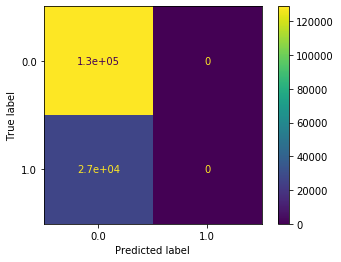

In [277]:
# Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix, classification_report, plot_roc_curve, plot_precision_recall_curve 

plot_confusion_matrix(model_dt,x_test,y_test)
print(metrics.confusion_matrix(y_test, y_pred))

In [248]:
MODELS = config.MODELS
PARAMS = config.PARAMS
model_key = "RandomForestClassifier"

model = MODELS[model_key]
params = PARAMS[model_key]        

target = config.target_vars[0]

# Include race/gender/ethnicity or exclude?
config.categorical_vars_to_impute

['CONTROL_STATUS', 'OFFENSE_CLEAN', 'Current_Offense_Risk_Level', 'year_month']

In [249]:
#scorer = make_scorer(precision_score, average = None)
#gs_svc = GridSearchCV(estimator=svc_clf,param_grid=param_grid,scoring=scorer,cv=5)

#scoring = {'recall': make_scorer(recall_score, average = 'macro'), 'precision': make_scorer(precision_score, average = 'macro'), 'accuracy': make_scorer(accuracy_score)}
scoring = {'recall': make_scorer(recall_score), 'precision': make_scorer(precision_score), 'accuracy': make_scorer(accuracy_score)}

grid_model = GridSearchCV(estimator=model, 
                          param_grid=params, 
                          cv=ps,
                          return_train_score=True,
                          scoring=scoring,
                             refit=False)



In [250]:
rf_grid_model_result = grid_model.fit(train_data.loc[:,train_data.columns!=target],train_data[target])


/Users/daminisharma/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/daminisharma/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/daminisharma/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/daminisharma/miniconda3/lib/python3.7/s

/Users/daminisharma/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/daminisharma/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/daminisharma/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/daminisharma/miniconda3/lib/python3.7/s

/Users/daminisharma/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/daminisharma/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/daminisharma/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/daminisharma/miniconda3/lib/python3.7/s

/Users/daminisharma/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/daminisharma/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/daminisharma/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/daminisharma/miniconda3/lib/python3.7/s

/Users/daminisharma/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/daminisharma/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/daminisharma/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/daminisharma/miniconda3/lib/python3.7/s

/Users/daminisharma/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/daminisharma/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/daminisharma/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/daminisharma/miniconda3/lib/python3.7/s

/Users/daminisharma/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/daminisharma/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/daminisharma/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/daminisharma/miniconda3/lib/python3.7/s

/Users/daminisharma/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/daminisharma/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/daminisharma/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/daminisharma/miniconda3/lib/python3.7/s

/Users/daminisharma/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/daminisharma/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/daminisharma/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/daminisharma/miniconda3/lib/python3.7/s

In [254]:
cv_results = pd.DataFrame(rf_grid_model_result.cv_results_)

ranked_cv=cv_results.sort_values(by=['rank_test_precision'])
ranked_cv[['param_criterion','param_max_depth','param_min_samples_split','param_n_estimators','rank_test_accuracy', 'mean_test_accuracy','mean_test_recall','mean_test_precision']]


,param_criterion,param_max_depth,param_min_samples_split,param_n_estimators,rank_test_accuracy,mean_test_accuracy,mean_test_recall,mean_test_precision
0,gini,1,2,100,1,0.808621,0.5,0.404311
29,entropy,1,2,5000,1,0.808621,0.5,0.404311
30,entropy,1,5,100,1,0.808621,0.5,0.404311
31,entropy,1,5,1000,1,0.808621,0.5,0.404311
32,entropy,1,5,5000,1,0.808621,0.5,0.404311
33,entropy,1,10,100,1,0.808621,0.5,0.404311
34,entropy,1,10,1000,1,0.808621,0.5,0.404311
35,entropy,1,10,5000,1,0.808621,0.5,0.404311
36,entropy,3,2,100,1,0.808621,0.5,0.404311
37,entropy,3,2,1000,1,0.808621,0.5,0.404311


In [259]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
%matplotlib inline

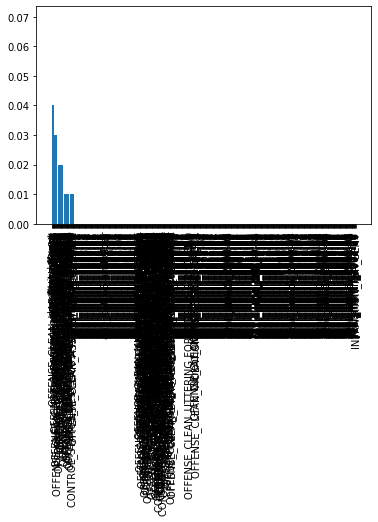

In [260]:
labels = train_data.loc[:,train_data.columns!=target].columns.values
features = train_data.loc[:,train_data.columns!=target].values
target_vals = train_data[target].values

dt = RandomForestClassifier(random_state=1234,max_depth=None,min_samples_split=5,criterion='gini',n_estimators=1000)
model_rf = dt.fit(features,target_vals)

# Get feature importances
importances = model_rf.feature_importances_

# Sort in descending order
indices = np.argsort(importances)[::-1]

# Sort the labels in a corresponding fashion
names = [labels[i] for i in indices]

# Plot
plt.figure()
plt.bar(range(features.shape[1]),importances[indices])
plt.xticks(range(features.shape[1]), names, rotation=90)
plt.show()

In [271]:
# prediction on test set
x_test = test_data.loc[:,test_data.columns!=target]
y_pred = model_rf.predict(x_test)
y_test = test_data.loc[:,target]


[[128951      0]
 [ 26831      0]]


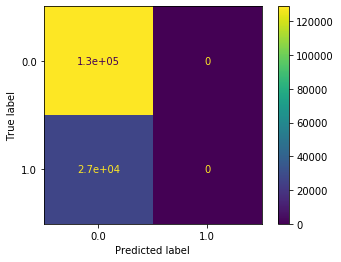

In [273]:
# Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix, classification_report, plot_roc_curve, plot_precision_recall_curve 

plot_confusion_matrix(model_rf,x_test,y_test)
print(metrics.confusion_matrix(y_test, y_pred))

In [267]:
names[:5]

['misd_count',
 'juv_first_offense',
 'age_first_offense',
 'sentence_count',
 'age_at_sentence']

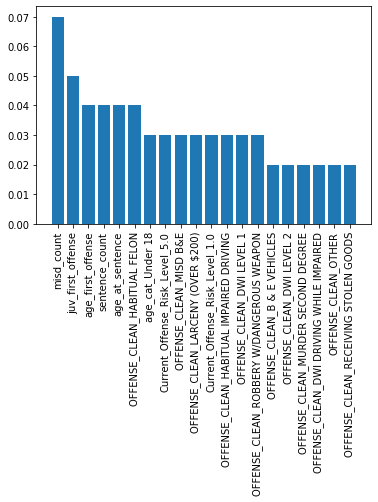

In [278]:
# Sort in descending order
indices = np.argsort(importances)[::-1]

# Sort the labels in a corresponding fashion
names = [labels[i] for i in indices]

# Plot
plt.figure()
plt.bar(range(20),importances[indices[:20]])
plt.xticks(range(20), names[:20], rotation=90)
plt.show()

In [ ]:
# TRY A SMALL SUBSET WTF IS GOING ON WIHT OUR MODELS ABOVE

In [293]:
# subset
subset_vars = names[:40]

train_subset = train_data.loc[:,subset_vars+[target]]
validate_subset = validate_data.loc[:,subset_vars+[target]]

ps = PredefinedSplit(test_fold=validate_subset[target])



In [294]:
MODELS = config.MODELS
PARAMS = config.PARAMS
model_key = "LogisticRegression"

model = MODELS[model_key]
params = PARAMS[model_key]        

target = config.target_vars[0]

# Include race/gender/ethnicity or exclude?
config.categorical_vars_to_impute

['CONTROL_STATUS', 'OFFENSE_CLEAN', 'Current_Offense_Risk_Level', 'year_month']

In [295]:
#scorer = make_scorer(precision_score, average = None)
#gs_svc = GridSearchCV(estimator=svc_clf,param_grid=param_grid,scoring=scorer,cv=5)

scoring = {'recall': make_scorer(recall_score), 'precision': make_scorer(precision_score), 'accuracy': make_scorer(accuracy_score)}
grid_model = GridSearchCV(estimator=model, 
                          param_grid=params, 
                          cv=ps,
                          return_train_score=True,
                          scoring=scoring,
                             refit=False)



In [296]:
grid_model_result = grid_model.fit(train_subset.loc[:,train_subset.columns!=target],train_subset[target])


/Users/daminisharma/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/Users/daminisharma/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/Users/daminisharma/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/Users/daminisharma/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/Users/daminisharma/miniconda3/lib/python3.7/site-packag

In [297]:
cv_results = pd.DataFrame(grid_model.cv_results_)

ranked_cv=cv_results.sort_values(by=['rank_test_precision'])
ranked_cv[['param_C','param_max_iter','param_penalty','rank_test_accuracy', 'mean_test_accuracy','mean_test_recall','mean_test_precision']]


,param_C,param_max_iter,param_penalty,rank_test_accuracy,mean_test_accuracy,mean_test_recall,mean_test_precision
0,0.01,1000,l2,1,0.809122,0.022605,0.530686
1,0.01,1000,none,2,0.809073,0.028503,0.523283
3,0.1,1000,none,2,0.809073,0.028503,0.523283
5,1,1000,none,2,0.809073,0.028503,0.523283
7,10,1000,none,2,0.809073,0.028503,0.523283
9,100,1000,none,2,0.809073,0.028503,0.523283
8,100,1000,l2,7,0.809044,0.028384,0.522206
6,10,1000,l2,7,0.809044,0.028435,0.522201
2,0.1,1000,l2,9,0.809019,0.027136,0.520937
4,1,1000,l2,10,0.809008,0.028240,0.520195


In [298]:
labels = train_subset.loc[:,train_subset.columns!=target].columns.values
features = train_subset.loc[:,train_subset.columns!=target].values
target_vals = train_subset[target].values

#dt = RandomForestClassifier(random_state=1234,max_depth=None,min_samples_split=5,criterion='gini',n_estimators=1000)
#dt = DecisionTreeClassifier(random_state=1234,max_depth=5,min_samples_split=5,criterion='entropy')
dt = LogisticRegression(random_state=1234,C=0.01,max_iter=1000,penalty='l2')
model_dt = dt.fit(features,target_vals)



In [299]:
test_subset = test_data.loc[:,subset_vars+[target]]


In [300]:
# prediction on test set
x_test = test_subset.loc[:,test_subset.columns!=target]
y_pred = model_dt.predict(x_test)
y_test = test_subset.loc[:,target]


[[128341    610]
 [ 26228    603]]


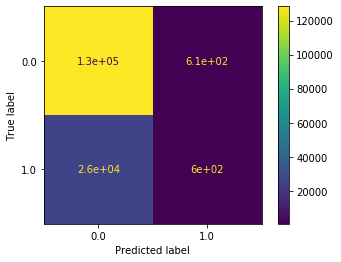

In [301]:
# Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix, classification_report, plot_roc_curve, plot_precision_recall_curve 

plot_confusion_matrix(model_dt,x_test,y_test)
print(metrics.confusion_matrix(y_test, y_pred))

In [243]:
#cv_results

In [ ]:
# THREE CLASS VAR

In [ ]:
# 5 CLASS VAR

In [224]:
#model = LogisticRegression(random_state=1234, solver='lbfgs')

In [225]:
#model.fit(train_data.loc[:,train_data.columns!=target],train_data[target])

In [226]:
#validate_predict = model.predict(validate_data.loc[:,validate_data.columns!=target])

In [227]:
#accuracy = accuracy_score(validate_data[target],validate_predict)


In [228]:
#accuracy

In [184]:
print("Accuracy:\t{}\nPrecision:\t{}\nRecall:\t\t{}\nF1 Score:\t{}\n".format(accuracy_score(validate_data[target], validate_predict),
                                                                           precision_score(validate_data[target], validate_predict,average=None),
                                                                           recall_score(validate_data[target], validate_predict,average=None),
                                                                           f1_score(validate_data[target], validate_predict,average=None)
                                                                          ))

Accuracy:	0.8230410917313178
Precision:	[0.82725468 0.15324675 0.11285266 0.14035088 0.         0.        ]
Recall:		[0.9961088  0.00917431 0.00591522 0.00115274 0.         0.        ]
F1 Score:	[0.9038633  0.01731221 0.01124122 0.00228669 0.         0.        ]



/Users/daminisharma/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [164]:
#train_data.dtypes

In [196]:
test_data.groupby(target).count()

,INFRACTION_PER_SENT,misd_count,felon_count,sentence_count,age_at_sentence,unemp_rate,age_first_offense,juv_first_offense,current_crime_violent,RACE_ASIAN/ORTL,RACE_BLACK,RACE_INDIAN,RACE_OTHER,RACE_UNKNOWN,RACE_WHITE,GENDER_FEMALE,GENDER_MALE,ETHNICITY_AFRICAN,ETHNICITY_AMERICAN INDIAN,ETHNICITY_ASIAN,ETHNICITY_EUROPEAN/N.AM./AUSTR,ETHNICITY_HISPANIC/LATINO,ETHNICITY_NORDIC/SCANDANAVIAN,ETHNICITY_ORIENTAL,ETHNICITY_OTHER,ETHNICITY_PACIFIC ISLANDER,ETHNICITY_SLAVIC (E. EUROPEAN),ETHNICITY_UNKNOWN,CONTROL_STATUS_HIGH SECURITY/MAX CONTROL HCON,CONTROL_STATUS_INTENSIVE CONTROL ICON,CONTROL_STATUS_MAXIMUM CONTROL MCON,CONTROL_STATUS_MODIFIED HOUSING MODH,CONTROL_STATUS_OUT OF CELL RESTRICTION OUTC,CONTROL_STATUS_PROTECTIVE CONTROL PCON,CONTROL_STATUS_REGULAR POPULATION RPOP,CONTROL_STATUS_REST.HOUS. ADMINISTRATIVE RHAP,CONTROL_STATUS_REST.HOUS. DISCIPLINARY RHDP,CONTROL_STATUS_RESTRCT HOUSNG 4 CTL PURP RHCP,OFFENSE_CLEAN_ARMED ROBBERY,OFFENSE_CLEAN_ASSAULT BY STRANGULATION,OFFENSE_CLEAN_ASSAULT INFLICT SERI BODY INJ,OFFENSE_CLEAN_ASSAULT ISI,OFFENSE_CLEAN_ASSAULT ON FEMALE,OFFENSE_CLEAN_ASSAULT ON OFFICER/ST EMPLOYEE,OFFENSE_CLEAN_ASSAULT ON POLICEMAN,OFFENSE_CLEAN_ASSAULT ON PUBLIC OFFICIAL,OFFENSE_CLEAN_AWDW,OFFENSE_CLEAN_AWDW GOV OFFICERS/EMPLOYEES,OFFENSE_CLEAN_AWDWISI,OFFENSE_CLEAN_AWDWWITKISI,OFFENSE_CLEAN_B & E & L,OFFENSE_CLEAN_B & E VEHICLES,OFFENSE_CLEAN_BURGLARY 1ST DEGREE,OFFENSE_CLEAN_BURGLARY 2ND DEGREE,OFFENSE_CLEAN_CHEAT - PROPERTY/SERVICES,OFFENSE_CLEAN_COMMON LAW FORGERY,OFFENSE_CLEAN_COMMON LAW ROBBERY,OFFENSE_CLEAN_COMMUNICATING THREATS,OFFENSE_CLEAN_CREDIT CARD THEFT,OFFENSE_CLEAN_DAMAGE TO PROPERTY,OFFENSE_CLEAN_DEL/SELL SCHEDULE II,OFFENSE_CLEAN_DISCHG FIREARM-OCC PROPERTY,OFFENSE_CLEAN_DRIV LICENSE PERM RVK,OFFENSE_CLEAN_DRIV LICENSE REVOKED,OFFENSE_CLEAN_DRIVING UNDER INFLUENCE (DUI),OFFENSE_CLEAN_DRUG PARA - USE/POSSESS,OFFENSE_CLEAN_DWI DRIVING WHILE IMPAIRED,OFFENSE_CLEAN_DWI LEVEL 1,OFFENSE_CLEAN_DWI LEVEL 1 AGGRAVATED,OFFENSE_CLEAN_DWI LEVEL 2,OFFENSE_CLEAN_DWI LEVEL 3,OFFENSE_CLEAN_DWI LEVEL 4,OFFENSE_CLEAN_DWI LEVEL 5,OFFENSE_CLEAN_EMBEZZLEMENT,OFFENSE_CLEAN_FAIL TO REGISTER (SEX OFFENDER,OFFENSE_CLEAN_FELONY B&E,OFFENSE_CLEAN_FORGERY,OFFENSE_CLEAN_HABITUAL FELON,OFFENSE_CLEAN_HABITUAL IMPAIRED DRIVING,OFFENSE_CLEAN_HABITUAL MISDEMEANOR ASSAULT,OFFENSE_CLEAN_IDENTITY FRAUD/THEFT,OFFENSE_CLEAN_INDECENT LIBERTY W/CHILD,OFFENSE_CLEAN_INVOLUNTARY MANSLAUGHTER,OFFENSE_CLEAN_KIDNAPPING 2ND DEGREE,OFFENSE_CLEAN_LARCENY,OFFENSE_CLEAN_LARCENY (OVER $200),OFFENSE_CLEAN_LARCENY AFTER B & E,OFFENSE_CLEAN_LARCENY BY SERVANT/EMPLOYEE,OFFENSE_CLEAN_LARCENY FROM PERSON,OFFENSE_CLEAN_LARCENY OF FIREARMS,OFFENSE_CLEAN_LARCENY OF MOTOR VEHICLE,OFFENSE_CLEAN_LARCENY OVER $1000,OFFENSE_CLEAN_MAINT ANY PLACE CONTR SUB,OFFENSE_CLEAN_MANSLAUGHTER,OFFENSE_CLEAN_MISD B&E,OFFENSE_CLEAN_MURDER FIRST DEGREE,OFFENSE_CLEAN_MURDER SECOND DEGREE,OFFENSE_CLEAN_NON-SUPPORT,OFFENSE_CLEAN_OBT PROP BY FALSE PR/CHTS/SER,OFFENSE_CLEAN_OPERATE VEHICLE W/O LICENSE,OFFENSE_CLEAN_OTHER,OFFENSE_CLEAN_POSSESS SCHEDULE I,OFFENSE_CLEAN_POSSESS SCHEDULE II,OFFENSE_CLEAN_POSSESS SCHEDULE VI,OFFENSE_CLEAN_POSSESS WITS SCHEDULE I,OFFENSE_CLEAN_POSSESS WITS SCHEDULE II,OFFENSE_CLEAN_POSSESS WITS SCHEDULE VI,OFFENSE_CLEAN_POSSESSING STOLEN GOODS,OFFENSE_CLEAN_POSSESSION OF FIREARM BY FELON,OFFENSE_CLEAN_RAPE FIRST DEGREE,OFFENSE_CLEAN_RAPE SECOND DEGREE,OFFENSE_CLEAN_RECEIVING STOLEN GOODS,OFFENSE_CLEAN_RECEIVING STOLEN VEHICLE,OFFENSE_CLEAN_RESISTING OFFICER,OFFENSE_CLEAN_ROBBERY W/DANGEROUS WEAPON,OFFENSE_CLEAN_SELL SCHEDULE I,OFFENSE_CLEAN_SELL SCHEDULE II,OFFENSE_CLEAN_SELL SCHEDULE VI,OFFENSE_CLEAN_SEXUAL OFFENSE 2ND DEGREE,OFFENSE_CLEAN_SHOPLIFTING,OFFENSE_CLEAN_SPEED ELUDE ARREST/ATTEMPT/SEC,OFFENSE_CLEAN_SPEEDING ELUDE ARREST OR/ATTEM,OFFENSE_CLEAN_TRAFFICKING SCHEDULE I,OFFENSE_CLEAN_TRAFFICKING SCHEDULE II,OFFENSE_CLEAN_TRESPASS,OFFENSE_CLEAN_UNAUTH USE MOTOR CONVEYANCE,OFFENSE_CLEAN_UTTERING FORGEDPAPER/INST/END,OFFENSE_CLEAN_VIOLATION PROTE

In [186]:
test_predict = model.predict(test_data.loc[:,test_data.columns!=target])

In [187]:
print("Accuracy:\t{}\nPrecision:\t{}\nRecall:\t\t{}\nF1 Score:\t{}\n".format(accuracy_score(test_data[target], test_predict),
                                                                           precision_score(test_data[target], test_predict,average=None),
                                                                           recall_score(test_data[target], test_predict,average=None),
                                                                           f1_score(test_data[target], test_predict,average=None)
                                                                          ))

Accuracy:	0.8275217932752179
Precision:	[0.82893432 0.34375    0.36981132 0.10638298 0.25       0.        ]
Recall:		[9.98557592e-01 5.67375887e-03 1.32647537e-02 5.78235226e-04
 3.95569620e-04 0.00000000e+00]
F1 Score:	[9.05873952e-01 1.11632627e-02 2.56108716e-02 1.15021854e-03
 7.89889415e-04 0.00000000e+00]



/Users/daminisharma/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
